# Home Credit Default Risk - Machine Learning Project  

## Project Overview  
This project aims to predict **loan default risk** using historical credit data provided by the **Home Credit dataset**.  
By analyzing multiple financial datasets from past loan applications, we extract insights to improve risk assessment and minimize losses for lenders.  
While this model is trained specifically on Home Credit’s dataset, the process—data collection, preprocessing, feature engineering, and modeling—can be adapted to other financial institutions.  

## Live Application Deployment  
This project is also deployed as an **interactive Angular + Flask application**, allowing users to observe real-time model inference.  
🔗 **Try it here:** [Live Loan Default Predictor](https://ai.fullstackista.com/ai-loan-default-predictor/)  

### Key Steps in the Project  
1. **Understanding the Problem** – Define the objective: predict loan default risk using Home Credit data.  
2. **Data Processing & Feature Engineering** – Process multiple datasets, clean missing values, extract features, and aggregate information.  
3. **Exploratory Data Analysis (EDA)** – Identify trends, correlations, and risk factors in loan applications.  
4. **Merging Datasets** – Integrate primary (`application_train.csv`) and secondary datasets (e.g., `bureau.csv`, `credit_card_balance.csv`) for a unified view.  
5. **Model Training & Hyperparameter Tuning** – Train and optimize models (e.g., LightGBM) for predictive performance.  
6. **Model Evaluation** – Validate performance using metrics such as AUC-ROC.  
7. **Final Prediction** – Apply the trained model to `application_test.csv` and generate predictions.  

## About This Notebook

This notebook builds the final machine learning model for **Home Credit Default Risk Prediction**.  
It merges all preprocessed datasets, trains a model (LightGBM), and evaluates its performance.  

### Key Steps:
- **Merging Datasets** – Combines `application_train.csv` with all processed secondary datasets.
- **Model Training** – Uses LightGBM for classification and optimizes hyperparameters.
- **Model Evaluation** – Assesses performance using AUC-ROC and validates results with K-Fold Cross-Validation.

**Note**: Feature engineering on secondary datasets was performed in their respective notebooks. This notebook applies final transformations and model training.

## Project Notebooks  

### Main Dataset and Model Training  
- [1. Application Train (Main Dataset)](./01_application_train.ipynb) 
- [2. Model Training and Final Pipeline](./02_model_training_pipeline.ipynb) _(Current Notebook)_

### Secondary Datasets Processing  
- [3. Bureau Data](./03_bureau_data.ipynb)  
- [4. Bureau Balance Data](./04_bureau_balance.ipynb)  
- [5. Credit Card Balance](./05_credit_card_balance.ipynb)  
- [6. Previous Applications](./06_previous_applications.ipynb)  
- [7. POS Cash Balance](./07_pos_cash_balance.ipynb)  
- [8. Installments Payments](./08_installments_payments.ipynb)  

### Final Prediction  
- [9. Model Predictions on Test Data](./09_model_predictions.ipynb)  
- [10. Application Test Data Processing](./10_application_test_processing.ipynb)


# Model Training (All Datasets)

## 1. Load All Processed Datasets

### 1.1 Load Required Libraries  
Import necessary Python libraries for data processing, modeling, and visualization.  

In [1]:
# Import Libraries
import os
import pandas as pd
import json
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### 1.2 Define Dataset Path  
Set the file path where the processed datasets are stored.  

In [2]:
# Define dataset path
DATASET_PATH = "/kaggle/input/home-credit-processed-data-and-model/"

### 1.3 Load Processed Datasets  
Load all preprocessed datasets from the specified directory.  
These datasets include the main application data and various secondary datasets that provide additional financial and credit history details for loan applicants.  

In [3]:
# Load data from processed dataset
df_application_train_processed = pd.read_pickle(DATASET_PATH + "application_train_processed.pkl")
df_bureau_aggregated = pd.read_pickle(DATASET_PATH + "bureau_aggregated.pkl")
df_bureau_balance_aggregated_with_curr_final = pd.read_pickle(DATASET_PATH + "bureau_balance_aggregated_with_curr_final.pkl")
df_pos_cash_balance_aggregated = pd.read_pickle(DATASET_PATH + "pos_cash_balance_aggregated.pkl")
df_credit_card_balance_aggregated = pd.read_pickle(DATASET_PATH + "credit_card_balance_aggregated.pkl")
df_previous_application_aggregated = pd.read_pickle(DATASET_PATH + "previous_application_aggregated.pkl")
df_installments_payments_aggregated = pd.read_pickle(DATASET_PATH + "installments_payments_aggregated.pkl")

# Confirm successful loading
print("✅ All datasets loaded successfully from Kaggle dataset")

✅ All datasets loaded successfully from Kaggle dataset


### 1.4 Check Dataset Shapes  
Display the number of rows and columns in each dataset to ensure proper loading.  

In [4]:
# Quick check of shapes
print("Dataset Shapes:")
print(f"Application Train Processed: {df_application_train_processed.shape}")
print(f"Bureau Aggregated: {df_bureau_aggregated.shape}")
print(f"Bureau Balance Aggregated with Curr Final: {df_bureau_balance_aggregated_with_curr_final.shape}")
print(f"POS Cash Balance Aggregated: {df_pos_cash_balance_aggregated.shape}")
print(f"Credit Card Balance Aggregated: {df_credit_card_balance_aggregated.shape}")
print(f"Previous Application Aggregated: {df_previous_application_aggregated.shape}")
print(f"Installments Payments Aggregated: {df_installments_payments_aggregated.shape}")

Dataset Shapes:
Application Train Processed: (307511, 81)
Bureau Aggregated: (305811, 56)
Bureau Balance Aggregated with Curr Final: (134542, 63)
POS Cash Balance Aggregated: (337252, 36)
Credit Card Balance Aggregated: (103558, 99)
Previous Application Aggregated: (338857, 109)
Installments Payments Aggregated: (339587, 62)


### 1.5 Final Check: ID Columns in Merged Datasets
- This check ensures that **no unwanted ID-related columns** (e.g., system-generated IDs) accidentally sneak into the training dataset.
- **`SK_ID_CURR` is the primary key** used to merge datasets and should not be removed.
- **`DAYS_ID_PUBLISH` is an important time-related feature** and should not be excluded.
- If additional unexpected ID columns appear, they should be investigated and removed if necessary.

In [5]:
# Define datasets
datasets = {
    "Application Train": df_application_train_processed,
    "Bureau Aggregated": df_bureau_aggregated,
    "Bureau Balance Aggregated with Curr Final": df_bureau_balance_aggregated_with_curr_final,
    "POS Cash Balance Aggregated": df_pos_cash_balance_aggregated,
    "Credit Card Balance Aggregated": df_credit_card_balance_aggregated,
    "Previous Application Aggregated": df_previous_application_aggregated,
    "Installments Payments Aggregated": df_installments_payments_aggregated,
}

### 1.6 Display Summary of ID Columns in Merged Datasets  
This table lists the ID-related columns found in each dataset.  
It helps verify that only the correct primary key (`SK_ID_CURR`) is present and that no unnecessary ID columns remain.  

In [6]:
# Create a list to store results
sk_id_summary_list = []

for name, df in datasets.items():
    # Get all column names
    all_columns = df.columns.tolist()
    
    # Extract columns that contain "_id_" (case-insensitive search)
    id_cols = [col for col in all_columns if "_id_" in col.lower()]

    # Append results
    sk_id_summary_list.append({
        "Dataset": name,
        "ID Columns": ", ".join(id_cols) if id_cols else "None"
    })

# Convert to DataFrame
sk_id_summary = pd.DataFrame(sk_id_summary_list)

# Display results
print("Updated ID Column Summary:")
print(sk_id_summary.to_string(index=False))

Updated ID Column Summary:
                                  Dataset                  ID Columns
                        Application Train SK_ID_CURR, DAYS_ID_PUBLISH
                        Bureau Aggregated                  SK_ID_CURR
Bureau Balance Aggregated with Curr Final                  SK_ID_CURR
              POS Cash Balance Aggregated                  SK_ID_CURR
           Credit Card Balance Aggregated                  SK_ID_CURR
          Previous Application Aggregated                  SK_ID_CURR
         Installments Payments Aggregated                  SK_ID_CURR


### Observation  
- The **primary key `SK_ID_CURR`** is correctly present in all datasets.  
- The **`DAYS_ID_PUBLISH`** column appears in `application_train_processed`, but this is a time-related feature, not an unwanted ID column.  
- **No unexpected ID columns** were found, confirming that data merging has been done correctly without introducing data leakage.  

### 2. Merging Datasets  
Combine the processed secondary datasets with the main application training dataset.  
- All datasets are merged on **`SK_ID_CURR`**, the unique identifier for loan applications.  
- **Left joins (`how='left'`)** ensure that all records from the main dataset are retained, while missing values from secondary datasets are handled appropriately.  
- The resulting dataset will be used for model training.  

In [7]:
# Merge aggregated datasets with application train data
df_final = df_application_train_processed.merge(df_bureau_aggregated, on='SK_ID_CURR', how='left') \
                                         .merge(df_bureau_balance_aggregated_with_curr_final, on='SK_ID_CURR', how='left') \
                                         .merge(df_pos_cash_balance_aggregated, on='SK_ID_CURR', how='left') \
                                         .merge(df_credit_card_balance_aggregated, on='SK_ID_CURR', how='left') \
                                         .merge(df_previous_application_aggregated, on='SK_ID_CURR', how='left') \
                                         .merge(df_installments_payments_aggregated, on='SK_ID_CURR', how='left')

print("✅ Final dataset shape after merging:", df_final.shape)

✅ Final dataset shape after merging: (307511, 500)


### 2.1 Splitting Data for Model Training
- **80% of the data is used for training**, while **20% is reserved for validation**.
- The model will **learn patterns from the training set** and be evaluated on unseen validation data.

In [8]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Separate target and features
y = df_final["TARGET"]
X = df_final.drop(columns=["TARGET", "SK_ID_CURR"])

# Split into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Training Data Shape: {X_train.shape}")
print(f"✅ Validation Data Shape: {X_valid.shape}")

✅ Training Data Shape: (246008, 498)
✅ Validation Data Shape: (61503, 498)


### 2.2 Saving Final Feature Metadata for Inference & Deployment
- This step ensures **consistency between training, prediction, and the deployed application**.
- We save:
  - **Feature names** (ensuring inference data matches training data).
  - **Data types** (to prevent type mismatches during predictions).
  - **Categorical mappings** (for encoding categorical variables consistently).
- This JSON file will be **loaded in the prediction notebook and the deployed Flask app** to format new data correctly before making predictions.

In [9]:
# Prepare the training features
train_features = df_final.drop(columns=["TARGET", "SK_ID_CURR"]).columns.tolist()

# Extract data types for these features (using X which is already created as df_final without TARGET, SK_ID_CURR)
train_dtypes = X.dtypes.astype(str).to_dict()

# Store category mappings (for categorical columns) from X
category_mappings = {
    col: X[col].cat.categories.tolist() for col in X.select_dtypes(include=["category"]).columns
}

# Save all metadata to JSON
feature_metadata = {
    "features": train_features,
    "dtypes": train_dtypes,
    "category_mappings": category_mappings
}

with open("df_final_features.json", "w") as f:
    json.dump(feature_metadata, f)

print("✅ Saved df_final features, dtypes & categories to df_final_features.json")

✅ Saved df_final features, dtypes & categories to df_final_features.json


### 2.3 Calculating Imbalance Ratio
- **Loan default prediction is an imbalanced classification problem**.
- A high imbalance ratio means there are significantly more non-defaults than defaults.
- **This can bias the model** towards predicting non-defaults more often.
- Understanding this ratio helps in selecting appropriate techniques (e.g., resampling, weighted loss functions).

In [10]:
# Calculate imbalance ratio
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"✅ Class Imbalance Ratio: {imbalance_ratio:.2f}")

✅ Class Imbalance Ratio: 11.38


## 3. Model Training: Handling Imbalance & LightGBM Training
- **Addressing Class Imbalance:**  
  - The dataset is **imbalanced** (more non-defaulters than defaulters).
  - We **calculate the imbalance ratio** and use `scale_pos_weight` in LightGBM to adjust for this.
  
- **Preparing Categorical Features:**  
  - We **convert object-type columns** to the `"category"` dtype to optimize training.

- **Training the Model:**  
  - We train a **LightGBM classifier** optimized for **AUC (Area Under the Curve)**.
  - **Early stopping** prevents overfitting if the validation score stops improving for 50 rounds.

- **Evaluating Performance:**  
  - After training, we calculate the **AUC score on the validation set**.

In [11]:
# Convert categorical columns to 'category' dtype for LightGBM
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_valid[col] = X_valid[col].astype("category")

# Define LightGBM dataset
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature="auto")
dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature="auto", reference=dtrain)

# LightGBM hyperparameters tuned for better generalization and performance
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,    # Lower learning rate
    "num_leaves": 64,        # Increase leaves
    "max_depth": 8,          # Prevent overly deep trees
    "min_data_in_leaf": 50,  # Minimum data in one leaf
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.5,        # L1 regularization
    "lambda_l2": 0.5,        # L2 regularization
    "verbosity": -1,
    "seed": 42,
    "scale_pos_weight": imbalance_ratio  # Adjust for class imbalance
}

# Train LightGBM Model
model = lgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    valid_sets=[dvalid],
    valid_names=["valid"],
    callbacks=[lgb.early_stopping(50)]
)

# Make predictions on validation set
y_pred = model.predict(X_valid)

# Calculate AUC score
auc_score = roc_auc_score(y_valid, y_pred)

print(f"✅ LightGBM Model AUC: {auc_score:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1326]	valid's auc: 0.780743
✅ LightGBM Model AUC: 0.7807


## 4. ROC Curve & AUC: Evaluating Model Performance  
- **AUC (Area Under the Curve)** quantifies overall performance (**0.5 = random, 1.0 = perfect**).  
- The **blue curve** represents the model, while the **dashed line** is random guessing.
- The further the curve is from this diagonal, the better the model is at classification.

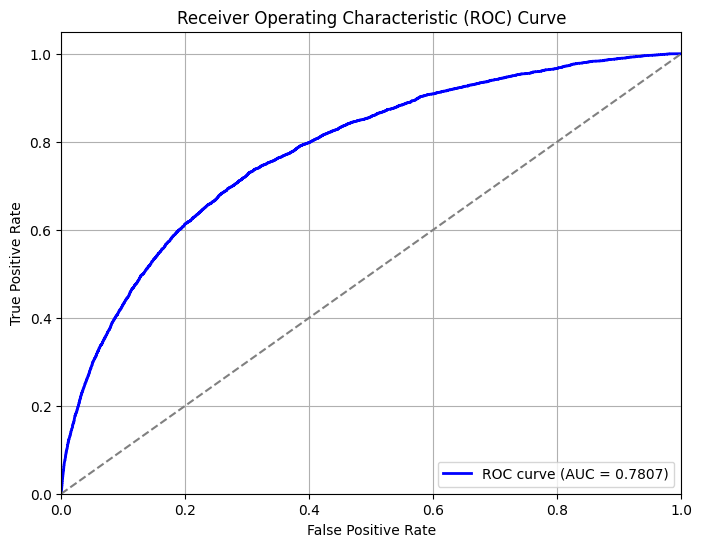

In [12]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Interpretation:
- **AUC of 0.78** indicates that the model performs significantly better than random guessing (**0.5**).  
- This suggests a **good ability to distinguish** between defaulters and non-defaulters.  
- **Further tuning** or **additional features** may improve performance.

## 5. Saving the Trained Model for Prediction & Deployment  
- We save the model in **two formats**:  
  - `.txt` → LightGBM **native format** (for reloading and further training).  
  - `.pkl` → **Deployment-ready format** (for direct inference in Flask, FastAPI, or other applications).  

In [13]:
# Save the trained LightGBM model
model.save_model("lightgbm_model.txt")  # LightGBM native format
joblib.dump(model, "lightgbm_loan_default.pkl")  # Deployment-ready format
print("✅ Final trained LightGBM model saved in both .txt and .pkl formats")

✅ Final trained LightGBM model saved in both .txt and .pkl formats


## 6. Feature Importance: Key Drivers of Loan Default Predictions
- Displays the **top 20 most influential features** in the model.
- Higher importance = **Greater impact on predictions**.
- Helps ensure the model is **learning meaningful patterns** and not over-relying on specific variables.


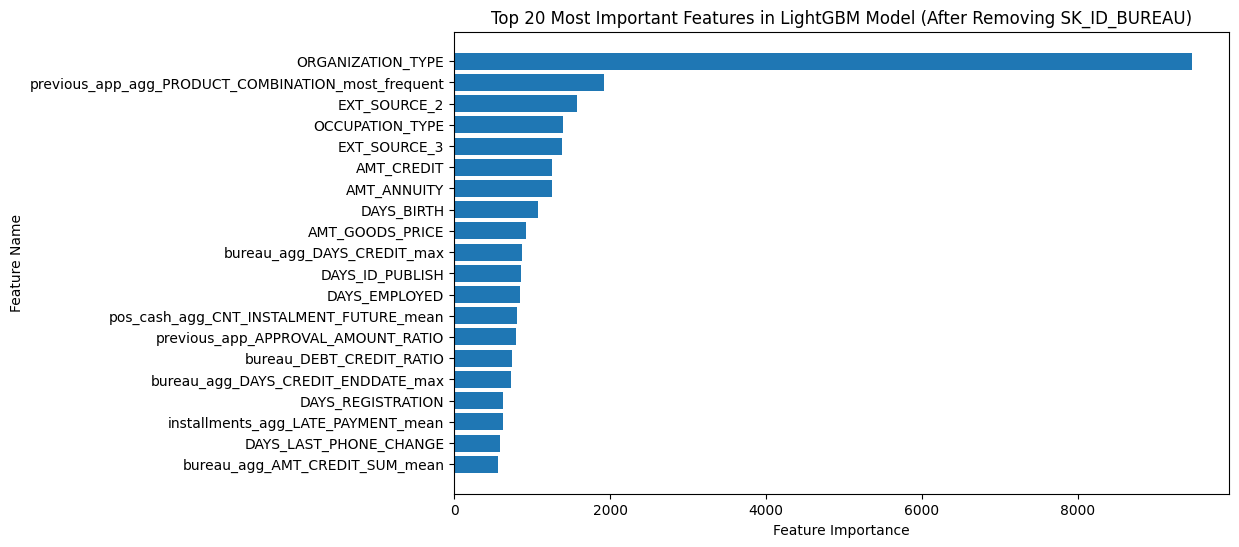

In [14]:
# Get feature importance
lgb_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importance()})
lgb_importance.sort_values(by="Importance", ascending=False, inplace=True)

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(lgb_importance["Feature"][:20], lgb_importance["Importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features in LightGBM Model (After Removing SK_ID_BUREAU)")
plt.show()

#### Key Insights
- "ORGANIZATION_TYPE" is the **most predictive feature**, indicating that the type of employer may be strongly correlated with default risk.
- Other significant features include previous loan combinations, external credit sources (EXT_SOURCE), and income-related attributes.
- This suggests that both **employment stability and external credit data** are important in predicting loan default.

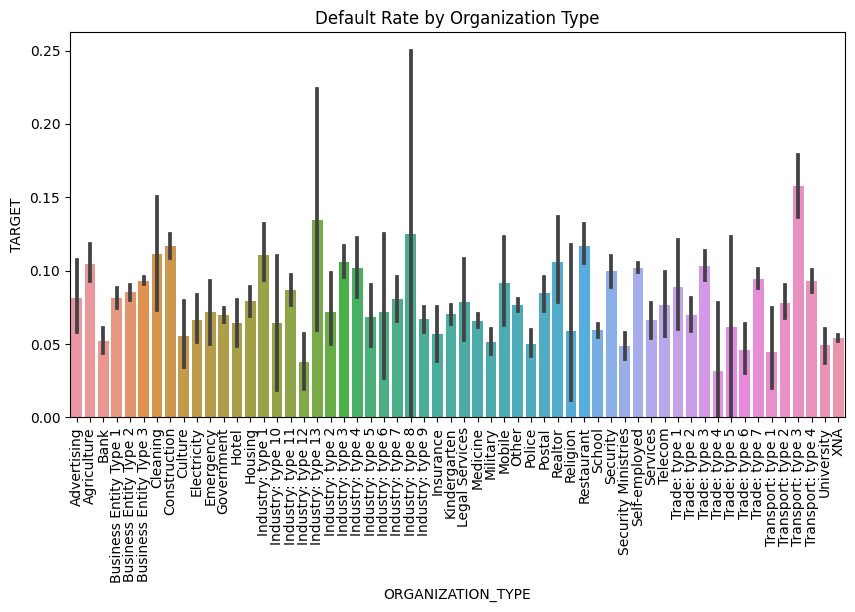

In [15]:
# Investigate how ORGANIZATION_TYPE relates to loan default
import seaborn as sns

plt.figure(figsize=(10, 5))

sns.barplot(x=df_final["ORGANIZATION_TYPE"], y=df_final["TARGET"])

plt.xticks(rotation=90)
plt.title("Default Rate by Organization Type")
plt.show()

#### Key Insights
- The **default rate varies significantly** by organization type.
- Some industries (e.g., industry, transport, trade) show **higher risk**, while others (e.g., bank, universities) have **lower default rates**. 

### 6.1 Evaluating Model Robustness: Training Without ORGANIZATION_TYPE feature
- The previous feature importance analysis showed that **ORGANIZATION_TYPE is the most influential feature**.
- However, high importance **does not always mean it is necessary**—it could introduce bias.
- To verify its actual impact, we **remove ORGANIZATION_TYPE and retrain the model**.
- We then compare the AUC score with and without this feature to **see if performance changes significantly**.

In [16]:
# Remove ORGANIZATION_TYPE from training data
X_train_reduced = X_train.drop(columns=["ORGANIZATION_TYPE"])
X_valid_reduced = X_valid.drop(columns=["ORGANIZATION_TYPE"])

# Define LightGBM dataset
dtrain_reduced = lgb.Dataset(X_train_reduced, label=y_train, categorical_feature="auto")
dvalid_reduced = lgb.Dataset(X_valid_reduced, label=y_valid, categorical_feature="auto")

# Retrain LightGBM
model_reduced = lgb.train(
    params,
    dtrain_reduced,
    num_boost_round=2000,
    valid_sets=[dvalid_reduced],
    valid_names=["valid"],
    callbacks=[lgb.early_stopping(50)]
)

# Make predictions on validation set
y_pred_reduced = model_reduced.predict(X_valid_reduced)

# Calculate AUC score without ORGANIZATION_TYPE
auc_score_reduced = roc_auc_score(y_valid, y_pred_reduced)

print(f"✅ AUC without ORGANIZATION_TYPE: {auc_score_reduced:.4f}")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1133]	valid's auc: 0.781277
✅ AUC without ORGANIZATION_TYPE: 0.7813


### Key Insights
- The AUC score without ORGANIZATION_TYPE (0.7813) is **very similar** to the original model (0.7807).
- This suggests that ORGANIZATION_TYPE, despite being highly ranked in feature importance, is **not critical** for prediction.
- This is a valuable insight for model simplification and generalization.

## 7. K-Fold Cross-Validation: Evaluating Model Stability
- To **ensure model reliability**, we perform **5-fold stratified cross-validation**.
- This **mitigates the risk of overfitting to a single train-validation split**.
- The model is trained on **5 different training-validation splits**, and AUC scores are averaged.
- A consistent **mean AUC across folds indicates model robustness**.

In [17]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_index, valid_index in kf.split(X, y):
    X_train_cv, X_valid_cv = X.iloc[train_index], X.iloc[valid_index]
    y_train_cv, y_valid_cv = y.iloc[train_index], y.iloc[valid_index]

    dtrain_cv = lgb.Dataset(X_train_cv, label=y_train_cv, categorical_feature="auto")
    dvalid_cv = lgb.Dataset(X_valid_cv, label=y_valid_cv, categorical_feature="auto")

    model_cv = lgb.train(
        params,
        dtrain_cv,
        num_boost_round=2000,
        valid_sets=[dvalid_cv],
        valid_names=["valid"],
        callbacks=[lgb.early_stopping(50)]
    )

    y_pred_cv = model_cv.predict(X_valid_cv)
    auc = roc_auc_score(y_valid_cv, y_pred_cv)
    auc_scores.append(auc)

print(f"✅ Cross-Validation AUC Scores: {auc_scores}")
print(f"✅ Mean AUC Score: {np.mean(auc_scores):.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1280]	valid's auc: 0.777978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1385]	valid's auc: 0.786246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1206]	valid's auc: 0.778447
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1306]	valid's auc: 0.782123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1330]	valid's auc: 0.779152
✅ Cross-Validation AUC Scores: [0.7779779443760646, 0.7862458330766147, 0.7784469531052938, 0.7821233805643876, 0.7791524914812624]
✅ Mean AUC Score: 0.7808


### Key Insights
- The AUC scores across folds are **stable, confirming the model generalizes well.**
- The **variation in AUC across folds is minimal**, suggesting consistent performance across different data subsets.
- This final validation step ensures **model reliability before deployment.**

### 7.1 Final Feature Importance (After Cross-Validation)
- This checks whether the most predictive features remain consistent after K-Fold CV.
- **Similar rankings** would indicate that the model learned stable patterns across different training splits.

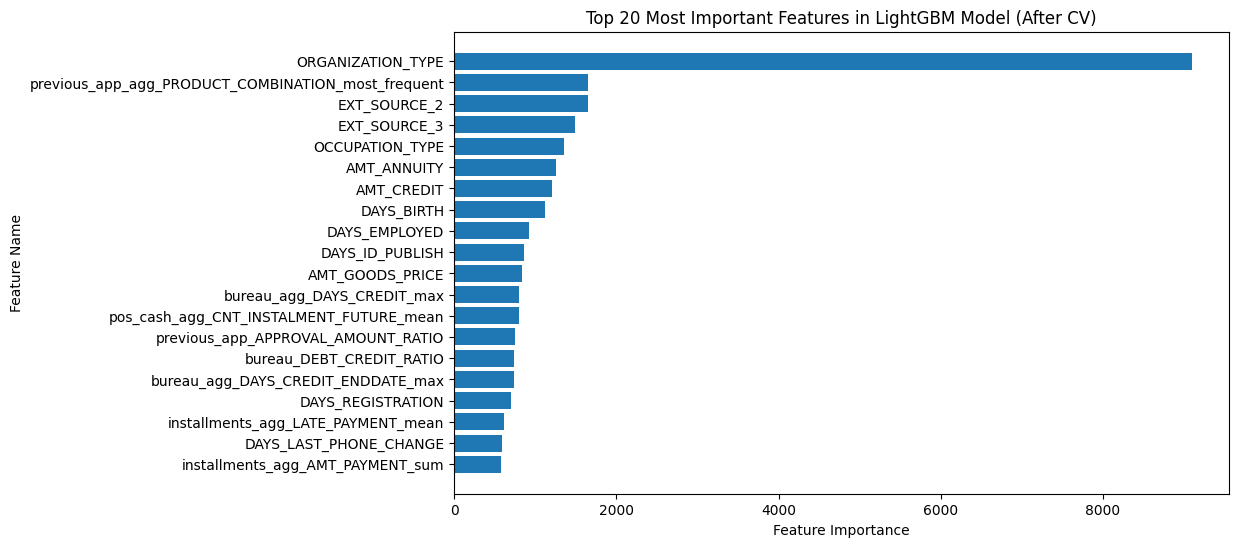

In [18]:
import matplotlib.pyplot as plt

# Get feature importance
lgb_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": model_cv.feature_importance()})
lgb_importance.sort_values(by="Importance", ascending=False, inplace=True)

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(lgb_importance["Feature"][:20], lgb_importance["Importance"][:20])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features in LightGBM Model (After CV)")
plt.show()

### Key Insights:
- **Top features remained stable** across K-Fold CV, confirming that the model consistently identifies **reliable predictors**.
- **Feature importance rankings did not change significantly**, reinforcing the model's ability to detect **key drivers of loan default**.
- **This consistency strengthens confidence** in the model's robustness before deployment.

## ✅  Final Summary

- The **LightGBM model** achieved an **AUC of ~0.78**, indicating strong predictive performance.  
- **Feature importance remained consistent** across K-Fold CV, confirming model robustness.  
- **Organization type**, while highly ranked, was **not critical** for prediction, showing the model generalizes well.  
- **Cross-validation results** suggest the model is **not overfitting** and is stable across different splits.  
- The trained model is **saved and ready for deployment**.  